# CatBoost models

## Data
We analyze a synthetic version of the data, created in the R script.
The synthetic dataset is a copy of the top 50 most important variables of the phase 4 dataset (age 11-12, $N=2224$, $p=380$ - analysed in the paper), together with a synthetic version of the outcome variable (SDQ score at age 15-16).

In [1]:
import numpy as np
import pandas as pd
from catboost import Pool, CatBoostClassifier, cv, EFstrType
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
from numba import NumbaDeprecationWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import shap

In [2]:
X = pd.read_csv("synthetic-dataset.csv")

y = X['TotaalSDQkind_f5'].values
y[np.where(y < np.percentile(y, 90))[0]] = 0
y[np.where(y >= np.percentile(y, 90))[0]] = 1

X = X.drop(['TotaalSDQkind_f5'], axis=1)

# subtract 1 because this is Python
categorical_features_indices = np.array([3,4,7,23,27,29,33,39,40,41,46])  - 1

categorical_features_indices=categorical_features_indices[1:]

# convert categorical feature values to strings
q = ['str']*len(categorical_features_indices)
foo = dict(zip(X.columns[categorical_features_indices], q))
X = X.astype(foo)

## Data splitting

In [3]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=123)

train_data = Pool(data = X_train,
                  label = y_train,
                  cat_features = categorical_features_indices)

validation_data = Pool(data = X_validation,
                  label = y_validation,
                  cat_features = categorical_features_indices)

## Train baseline

Before tuning any other parameters, we first tune learning rate and number of iterations manually with a trial run.

In [4]:
model = CatBoostClassifier(loss_function='Logloss',
                           class_weights=[0.1,0.9],
                           random_state=0)

model.fit(X_train, y_train, 
          cat_features = categorical_features_indices,
          eval_set=(X_validation, y_validation),
          verbose=500,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.036534
0:	learn: 0.6791421	test: 0.6838724	best: 0.6838724 (0)	total: 63.9ms	remaining: 1m 3s
500:	learn: 0.0656263	test: 0.8606128	best: 0.5800672 (67)	total: 1.55s	remaining: 1.54s
999:	learn: 0.0215479	test: 1.1155723	best: 0.5800672 (67)	total: 3.08s	remaining: 0us

bestTest = 0.5800671896
bestIteration = 67

Shrink model to first 68 iterations.


In the logging output we can read the iteration with the best value, the chosen learning rate, and the performance (measured in log-loss) on the evaluation set. 

## Grid search

To perform a grid search we use Scikit-learn GridsearchCV functionality. We first define the model with a sufficiently large number of iterations. In the fit() function we set the early_stopping_rounds parameter which ensures each model stops training after the loss function has not improved for a defined number of iterations. This saves a lot of time.
Because gridSearchCV by default maximizes the scoring function we use the negative log-loss (as the log-loss must be minimized). 

In [5]:
model = CatBoostClassifier(iterations=1e3,
                           class_weights=[0.1,0.9],
                           random_state=0)

# Define parameter grid
param_grid = {
    'depth': [2, 4, 6]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='neg_log_loss',#'roc_auc',
                           cv=5,
                           verbose=4)

grid_search.fit(X_train, y_train, 
                cat_features=categorical_features_indices,
                eval_set=(X_validation, y_validation),
                early_stopping_rounds=50,
                verbose=0) 

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..........................depth=2;, score=-0.507 total time=   0.4s
[CV 2/5] END ..........................depth=2;, score=-0.481 total time=   0.4s
[CV 3/5] END ..........................depth=2;, score=-0.534 total time=   0.4s
[CV 4/5] END ..........................depth=2;, score=-0.597 total time=   0.3s
[CV 5/5] END ..........................depth=2;, score=-0.531 total time=   0.4s
[CV 1/5] END ..........................depth=4;, score=-0.476 total time=   0.4s
[CV 2/5] END ..........................depth=4;, score=-0.459 total time=   0.4s
[CV 3/5] END ..........................depth=4;, score=-0.541 total time=   0.3s
[CV 4/5] END ..........................depth=4;, score=-0.562 total time=   0.3s
[CV 5/5] END ..........................depth=4;, score=-0.509 total time=   0.3s
[CV 1/5] END ..........................depth=6;, score=-0.464 total time=   0.4s
[CV 2/5] END ..........................depth=6;, 

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x11fe7a460>,
             param_grid={'depth': [2, 4, 6]}, scoring='neg_log_loss',
             verbose=4)

The best parameter combination can be found with the best_params_ method.

In [6]:
grid_search.best_params_

{'depth': 6}

We can also print an overview of the results.

In [7]:
gs_results = pd.DataFrame({'depth': grid_search.cv_results_['param_depth'],
                    'acc': grid_search.cv_results_["mean_test_score"]})

print(gs_results.sort_values(by=['acc'],ascending=False))

  depth       acc
2     6 -0.477480
1     4 -0.509194
0     2 -0.530013


## Train final model

We train the final model with the optimized tree depth.

In [8]:
model = CatBoostClassifier(loss_function='Logloss',
                           early_stopping_rounds=50,
                           depth=grid_search.best_params_['depth'],
                           class_weights=[0.1,0.9],
                           random_state=0)

model.fit(X_train, y_train, 
          cat_features = categorical_features_indices,
          eval_set=(X_validation, y_validation),
          verbose=500,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.036534
0:	learn: 0.6791421	test: 0.6838724	best: 0.6838724 (0)	total: 4.27ms	remaining: 4.27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5800671896
bestIteration = 67

Shrink model to first 68 iterations.


## Evaluate performance

We calculate several classification performances, both manually and using scikit-learn functionality where possibile.

In [9]:
preds = model.predict(X_validation)

probs = model.predict_proba(X_validation)

# Error rate / accuracy
errors=0
for i in range(len(y_validation)):
    if preds[i] != y_validation[i]:
        errors+=1
acc = 1 - errors/len(X_validation)

tp=0
fp=0
tn=0
fn=0
for i in range(len(preds)):
    if preds[i] == 1:
        if y_validation[i] == 1:
            tp += 1
        else:
            fp += 1
    if preds[i] == 0:
        if y_validation[i] == 0:
            tn += 1
        else:
            fn += 1

performances = pd.DataFrame({'AUC': ['-', roc_auc_score(y_validation, probs[:,1])],
                             'Accuracy': [acc, accuracy_score(y_validation,preds)],
                             'Sensitivity:': [tp/(tp+fn), recall_score(y_validation,preds)],
                             'Specificity:': [tn/(fp+tn), '-'],
                             'Precision:': [tp/(tp+fp), precision_score(y_validation,preds)],
                             'F-measure:': [2*tp/(2*tp+fp+fn), f1_score(y_validation,preds)],
                             'MCC': [((tp*tn)-(fp*fn)) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)),
                                     matthews_corrcoef(y_validation,preds)]}, index=['Manually', 'scikit-learn'])

performances.head()

,AUC,Accuracy,Sensitivity:,Specificity:,Precision:,F-measure:,MCC
Manually,-,0.773034,0.479167,0.808564,0.232323,0.312925,0.214608
scikit-learn,0.787049,0.773034,0.479167,-,0.232323,0.312925,0.214608


## ROC curve

In [10]:
fpr, tpr, thresholds = roc_curve(y_validation, probs[:,1], pos_label=1)

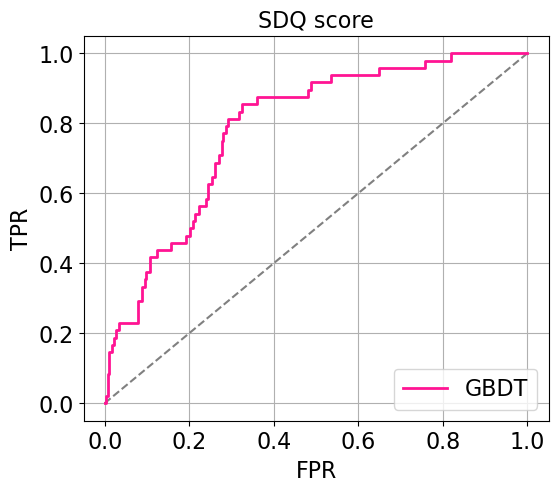

In [11]:
plt.figure(figsize=(6,5))#(8,6))
plt.plot([0,1],[0,1],"--",color="grey")
plt.plot(fpr,tpr, linewidth=2,color="deeppink",label="GBDT")
#plt.plot(1 - aucRF.specificities.values,aucRF.sensitivities.values,
#         linewidth=2,color="dodgerblue",label="Random Forest")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("FPR",fontsize = 16)
plt.ylabel("TPR",fontsize = 16)
plt.legend(fontsize=16,loc=4)
plt.title("SDQ score",fontsize=16)
plt.grid()
#plt.savefig('plots/AUC-curves-SDQ-fase4-01.jpg')
plt.show()

## SHAP analysis

We compute Shapley values using the SHAP Python package. The trained model object can be directly passed to the SHAP TreeExplainer. The TreeExplainer class can be called directly to compute SHAP values for a given dataset. The resulting SHAP values are hold by a so-called Explanation object which can be passed to plotting functions. Below we show the summary (beeswarm) plot, and a SHAP dependence scatter plot. 

In the current version of SHAP the argument 'group_remaining_features' cannot be toggled off, so that the sum of all remaining features is shown as a single feature at the bottom of the plot, which widens the horizontal scale. Therefore we use the summary plot function, which does not show this by default.

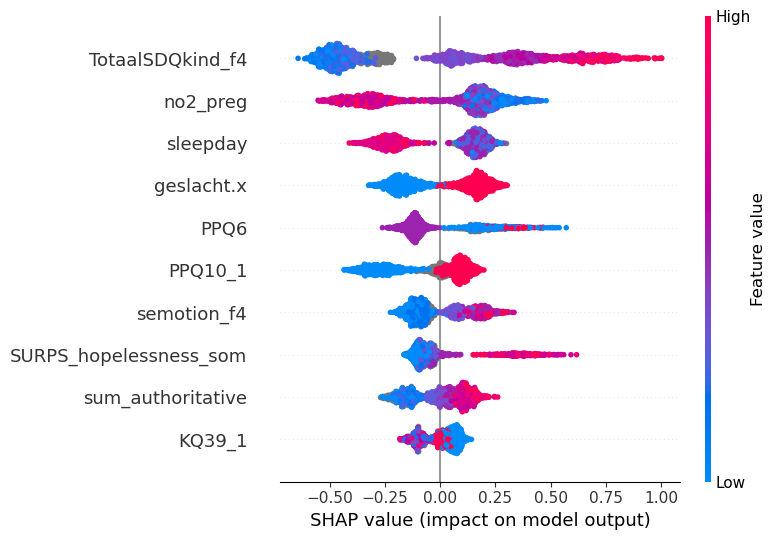

In [12]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

# create a summary plot
shap.summary_plot(shap_values, max_display=10)

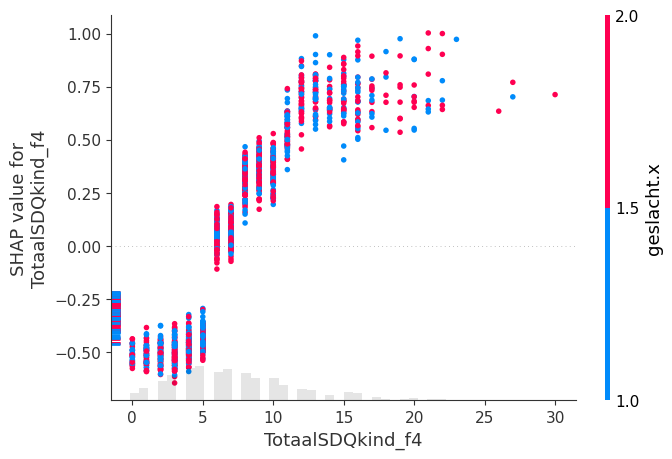

In [13]:
shap.plots.scatter(shap_values[:,"TotaalSDQkind_f4"], color=shap_values[:,"geslacht.x"])

# Interaction effects

The plot function shap.plots.scatter() uses the built-in function shap.utils.approximate_interactions() to approximate interaction effects.
The shap_interaction_values() method from the shap.TreeExplainer class produces more reliable estimates. We use it to select features with the strongest interaction effect, and use these for visualization in the dependence scatter plots.

The shap_interaction_values() method computes for each data point a $p\times p$ matrix, stored in a 3-dimensional array. We take a slice from this 3-dimensional matrix at the feature index of choice, for example 'TotaalSDQkind_f4'. For this feature we search the feature which has the highest sum of (absolute) interaction values over all data points. This will return the selected feature itself because the interaction value with itself is simply the SHAP value for that feature and will have the highest value. We therefore take the second highest value.

The strongest interacting variable for 'TotaalSDQkind_f4' is a variable for the estimation of enviromental air pollution due to NO$_2$ during pregnancy (no2_preg). 

In [14]:
shap_interaction_values = explainer.shap_interaction_values(X_train)

feature_idx = np.where(X.columns=='TotaalSDQkind_f4')[0][0]

print(pd.Series(X.columns[np.argsort(np.sum(np.abs(shap_interaction_values[:,feature_idx,:]),axis=0))[-20:]],
               index=np.arange(20,0,-1)).iloc[::-1])

interaction_feat_idx = X.columns[np.argsort(np.sum(np.abs(shap_interaction_values[:,feature_idx,:]),axis=0))[-2]]

1           TotaalSDQkind_f4
2                   no2_preg
3                    PPQ10_1
4                   sleepday
5           CEBQ_foodresp_f4
6     SURPS_hopelessness_som
7                       PPQ6
8                 sprosoc_f4
9           sum_werkgeheugen
10                      gew5
11                    KQ39_1
12                geslacht.x
13        TotaalSDQmoeder_f4
14         sum_authoritative
15       SURPS_sensation_som
16                      METS
17                 shyper_f4
18              leeftijdkind
19                    metint
20               semotion_f4
dtype: object


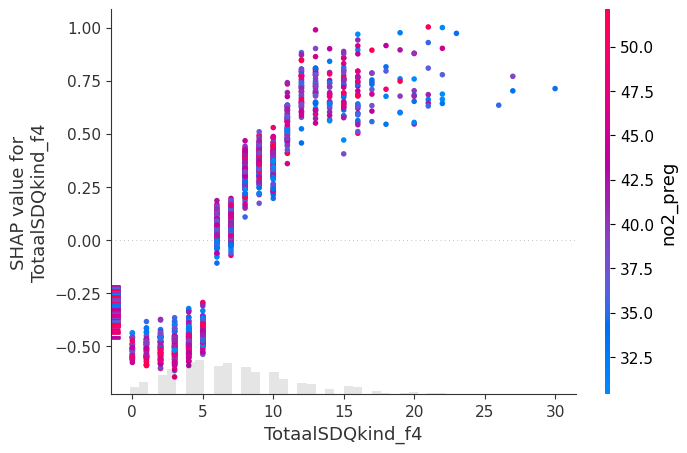

In [15]:
shap.plots.scatter(shap_values[:,"TotaalSDQkind_f4"], color=shap_values[:,interaction_feat_idx])